In [1]:
!pip install split-folders --quiet
!pip install torch torchvision transformers datasets --quiet
!pip install roboflow --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but 

In [2]:
!pip install ultralytics --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 824.8/824.8 kB 9.6 MB/s eta 0:00:00


In [3]:
!nvidia-smi

Wed Jul 24 12:31:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
from roboflow import Roboflow
rf = Roboflow(api_key="f92r8UAteQo539m5sPi1")
project = rf.workspace("esd-krexe").project("drowsiness-detection-0mcjg")
version = project.version(1)
dataset = version.download("folder")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Drowsiness-detection-1 in folder:: 100%|██████████| 9131/9131 [00:03<00:00, 2540.23it/s]


In [5]:
from transformers import ViTImageProcessor

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [6]:
from torchvision.transforms import (CenterCrop,
                                    Compose,
                                    Normalize,
                                    RandomHorizontalFlip,
                                    RandomResizedCrop,
                                    Resize,
                                    ToTensor)

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(image):
    return _train_transforms(image.convert("RGB"))

def val_transform(image):
    return _val_transforms(image.convert("RGB"))

In [7]:
import torchvision
from torchvision.transforms import ToTensor

train_ds = torchvision.datasets.ImageFolder('/content/Drowsiness-detection-1/train/', transform=train_transforms)
valid_ds = torchvision.datasets.ImageFolder('/content/Drowsiness-detection-1/valid/', transform=val_transform)
test_ds = torchvision.datasets.ImageFolder('/content/Drowsiness-detection-1/test/', transform=val_transform)

In [8]:
from transformers import ViTModel
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn
import torch.nn.functional as F

class ViTForImageClassification(nn.Module):
    def __init__(self, num_labels=3):
        super(ViTForImageClassification, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)
        self.num_labels = num_labels

    def forward(self, pixel_values, labels):
        outputs = self.vit(pixel_values=pixel_values)
        output = self.dropout(outputs.last_hidden_state[:,0])
        logits = self.classifier(output)

        loss = None
        if labels is not None:
          loss_fct = nn.CrossEntropyLoss()
          loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        if loss is not None:
          return logits, loss.item()
        else:
          return logits, None

In [9]:
import torch
model = ViTForImageClassification(len(train_ds.classes))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    model.cuda()

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_auc_curve(labels, predictions):
    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(labels, predictions)
    # Calculate the AUC
    roc_auc = auc(fpr, tpr)

    # Plotting the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Vision Transformer (ViT)

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


              precision    recall  f1-score   support

           0       0.95      0.94      0.94       478
           1       0.93      0.94      0.94       434

    accuracy                           0.94       912
   macro avg       0.94      0.94      0.94       912
weighted avg       0.94      0.94      0.94       912

Test Loss: 0.1560 | Test Accuracy: 0.94 | F1 Score: 0.94


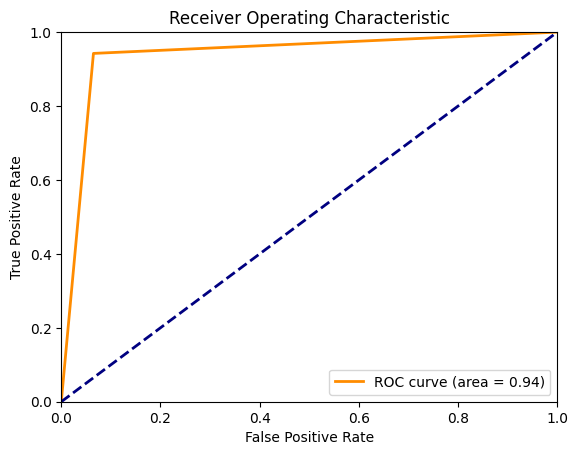

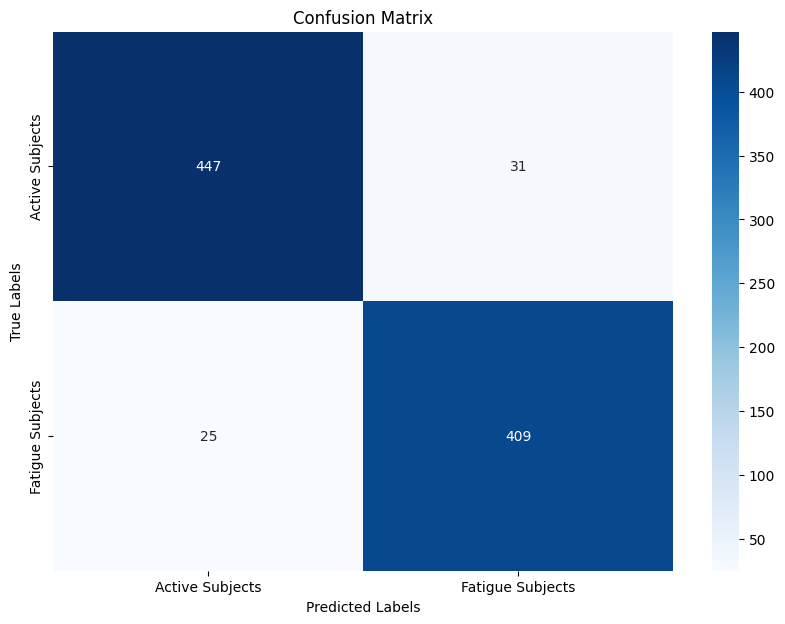

In [12]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import torch.utils.data as data
model.load_state_dict(torch.load('/content/drive/My Drive/ViT - patience - 5.pt'))
model.to(device)
model.eval()

test_loss = 0.0
correct = 0
total = 0
all_predictions = []
all_labels = []
eval_loader = data.DataLoader(test_ds, batch_size=1, shuffle=True, num_workers=4)

with torch.no_grad():
    for x, y in eval_loader:
        # Ensure x has the correct shape
        if len(x.shape) == 3:
            x = x.unsqueeze(0)  # Add batch dimension

        x = x.to(device)
        y = y.to(device)
        output, loss = model(x, y)
        test_loss += loss
        _, predicted = torch.max(output, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

        # Collect predictions and true labels for metrics
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# Average loss and accuracy
test_loss /= len(eval_loader)
accuracy = correct / total
f1 = f1_score(all_labels, all_predictions, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_predictions)
print(classification_report(all_labels, all_predictions))
print(f'Test Loss: {test_loss:.4f} | Test Accuracy: {accuracy:.2f} | F1 Score: {f1:.2f}')

# Plot confusion matrix
plot_roc_auc_curve(all_labels, all_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_ds.classes, yticklabels=train_ds.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# YOLOv8

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       478
           1       0.97      0.98      0.97       434

    accuracy                           0.97       912
   macro avg       0.97      0.97      0.97       912
weighted avg       0.97      0.97      0.97       912

Test Accuracy: 0.97 | F1 Score: 0.97


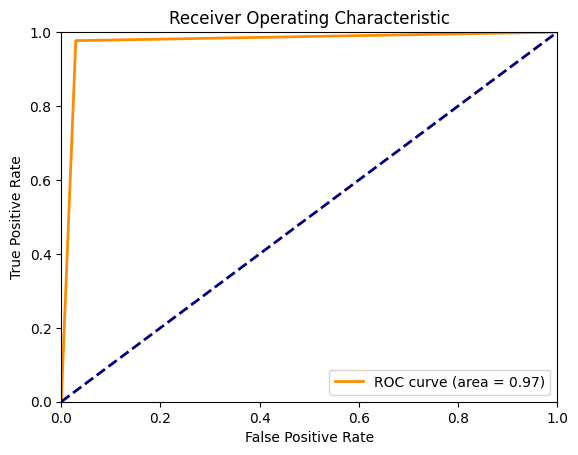

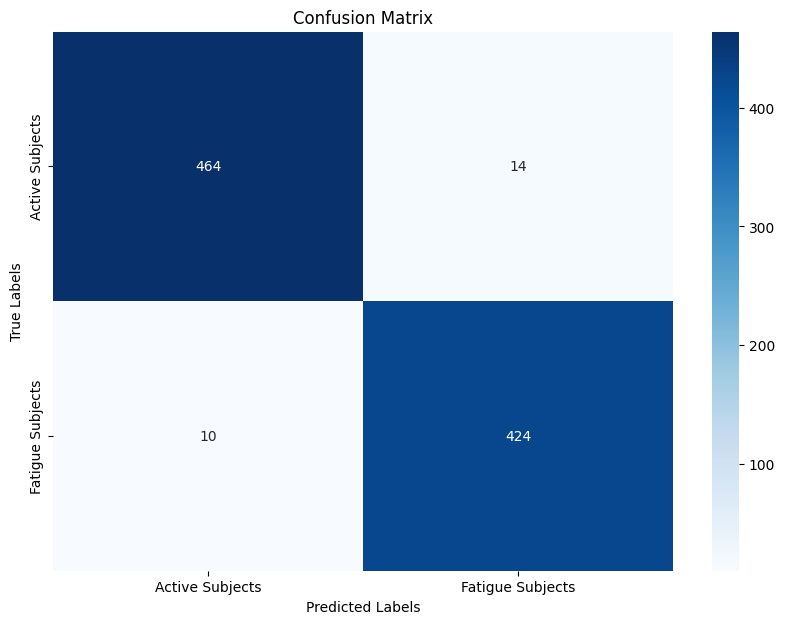

In [13]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import torch.utils.data as data
from ultralytics import YOLO
from torchvision.transforms import ToTensor
model = YOLO("/content/drive/MyDrive/YOLOv8 - 20 - Epochs.pt")
model.to(device)
test_ds = torchvision.datasets.ImageFolder('/content/Drowsiness-detection-1/test/')
results = []
true = []
for x, y in test_ds:
  results.append(model.predict(x, verbose=False)[0].probs.top1)
  true.append(y)

accuracy = accuracy_score(true, results)
f1 = f1_score(true, results, average='weighted')
conf_matrix = confusion_matrix(true, results)
print(classification_report(true, results))
print(f'Test Accuracy: {accuracy:.2f} | F1 Score: {f1:.2f}')

# Plot confusion matrix
plot_roc_auc_curve(true, results)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_ds.classes, yticklabels=train_ds.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Stacked Model

Testing: 100%|██████████| 57/57 [00:25<00:00,  2.21it/s]


              precision    recall  f1-score   support

           0       0.94      0.94      0.94       478
           1       0.93      0.94      0.94       434

    accuracy                           0.94       912
   macro avg       0.94      0.94      0.94       912
weighted avg       0.94      0.94      0.94       912

Test Loss: 0.1843 | Test Accuracy: 0.94 | F1 Score: 0.94


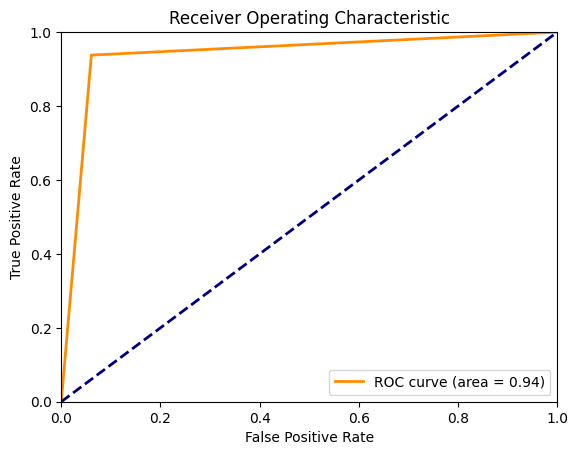

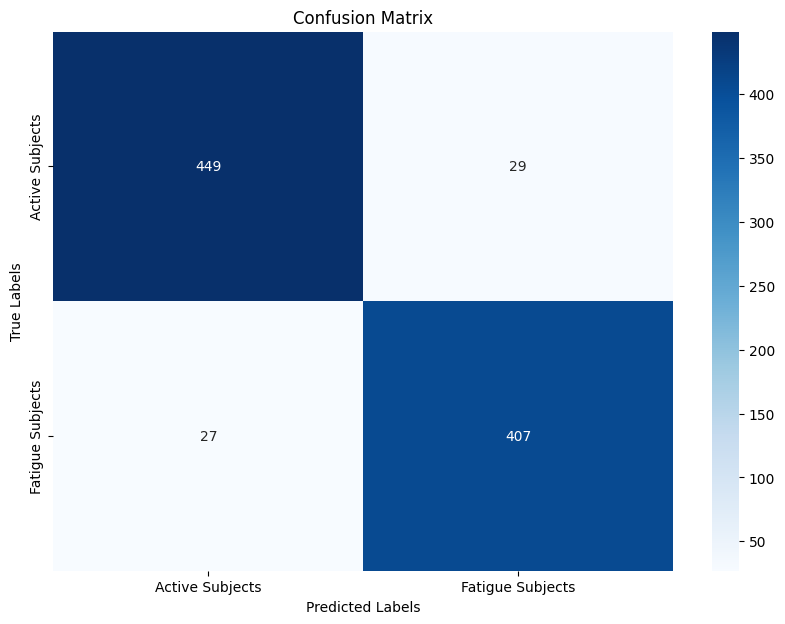

In [22]:
import torchvision
from torchvision.transforms import ToTensor
import torch
from ultralytics import YOLO
from PIL import Image
import numpy as np
import torch.nn as nn
import torch.utils.data as data
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from transformers import ViTImageProcessor
from torchvision.transforms import (CenterCrop,
                                    Compose,
                                    Normalize,
                                    RandomHorizontalFlip,
                                    RandomResizedCrop,
                                    Resize,
                                    ToTensor)
_val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(size),
            # ToTensor(),
            normalize,
        ]
    )

def val_transform(image):
    return _val_transforms(image)

test_ds = torchvision.datasets.ImageFolder('/content/Drowsiness-detection-1/test/', transform=ToTensor())

# Load ViT model
vit_model = ViTForImageClassification(2)
vit_model.load_state_dict(torch.load('/content/drive/My Drive/ViT - patience - 5.pt', map_location=device))
vit_model.eval()

# Load YOLO model
yolo_model = YOLO("/content/drive/MyDrive/YOLOv8 - 20 - Epochs.pt")

class MetaModel(nn.Module):
    def __init__(self, vit_model, yolo_model, num_classes):
        super(MetaModel, self).__init__()
        self.vit = vit_model
        self.yolo = yolo_model.model
        self.fc = nn.Linear(4, num_classes)

    def forward(self, pixel_values, labels):
        vit_input = val_transform(pixel_values)
        vit_logits, _ = self.vit(pixel_values=vit_input, labels=labels)

        yolo_logits = self.yolo(pixel_values)

        combined_features = torch.cat((vit_logits, yolo_logits), dim=1)
        logits = self.fc(combined_features)
        return logits

test_dataloader = data.DataLoader(test_ds, batch_size=16, shuffle=True)

meta_model = MetaModel(vit_model, yolo_model, 2)
meta_model.cuda()
criterion = nn.CrossEntropyLoss()
meta_model.load_state_dict(torch.load('/content/drive/MyDrive/MetaModel.pt'))
meta_model.to(device)
meta_model.eval()
test_loss = 0.0
test_correct = 0
total = 0
all_predictions = []
all_labels = []
with torch.no_grad():
  for batch in tqdm(test_dataloader, desc=f"Testing"):
    inputs, labels = batch
    inputs, labels = inputs.cuda(), labels.cuda()

    outputs = meta_model(inputs, labels)
    loss = criterion(outputs, labels)

    test_loss += loss.item()
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    test_correct += (predicted == labels).sum().item()

    all_predictions.extend(predicted.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

test_accuracy = test_correct / total
test_loss /= len(test_dataloader)
f1 = f1_score(all_labels, all_predictions, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_predictions)
print(classification_report(all_labels, all_predictions))
print(f'Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.2f} | F1 Score: {f1:.2f}')

# Plot confusion matrix
plot_roc_auc_curve(all_labels, all_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_ds.classes, yticklabels=test_ds.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()